In [10]:
import torch
from torch import nn
import random
import numpy as np

from torchvision import transforms
from torch.utils import data
from PIL import Image
import time
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

In [3]:
class Self_Attention(nn.Module):#Deconvolution時に大域的な情報を反映させたいので，各ピクセルごとに席を取るイメージ．近い値のほうが大きな値となる(相関が強い)
    #Self-Attetion's layer
    
    def __init__(self,in_dim):
        super(Self_Attention,self).__init__()
        #1*1の畳み込みそうによるpointwise convolutionを用意
        self.query_conv=nn.Conv2d(in_channels=in_dim,out_channels=int(in_dim/8),kernel_size=1)
        self.key_conv=nn.Conv2d(in_channels=in_dim,out_channels=int(in_dim/8),kernel_size=1)
        self.value_conv=nn.Conv2d(in_channels=in_dim,out_channels=in_dim,kernel_size=1)
        
        #Attention Map作成時の規格化のソフトマックス(行に関する正規化)
        self.Softmax=nn.Softmax(dim=-2)
        
        #もとの入力xとSelf-Atttention Mapであるoを足し算するときの係数
        #output=x+gamma*o
        #最初はgamma=0で学習させていく
        self.gamma=nn.Parameter(torch.zeros(1))
        
    def forward(self,x):
        X=x
        
        #畳み込みをしてからサイズを変形する．B,C,W,H → B,C',N
        proj_query=self.query_conv(X).view(X.shape[0],-1,X.shape[2]*X.shape[3])
        proj_query=proj_query.permute(0,2,1) #転置操作
        proj_key=self.key_conv(X).view(X.shape[0],-1,X.shape[2]*X.shape[3])
        
        #掛け算
        S=torch.bmm(proj_query,proj_key) #bmmはバッチごとの掛け算
        
        #規格化
        attention_map_T=self.Softmax(S) #行i方向の和を1にするソフトマックス関数
        attention_map=attention_map_T.permute(0,2,1)
        
        #Self-Attention Mapを計算する
        proj_value=self.value_conv(X).view(X.shape[0],-1,X.shape[2]*X.shape[3])
        o=torch.bmm(proj_value,attention_map.permute(0,2,1))
        
        #Self-Attention MapであるoのテンソルサイズをXにそろえて出力する
        o=o.view(X.shape[0],X.shape[1],X.shape[2],X.shape[3])
        out=x+self.gamma*o
        
        return out,attention_map

In [4]:
class Generator(nn.Module):
    
    def __init__(self,z_dim=20,image_size=64):
        super(Generator,self).__init__()
        
        self.layer1=nn.Sequential(
            #Spectral Normalization追加：networkの重みの規格化
            nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim,image_size*8,kernel_size=4,stride=1)),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True)
        )
        self.layer2=nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*8,image_size*4,kernel_size=4,stride=2,padding=1)),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True)
        )
        self.layer3=nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*4,image_size*2,kernel_size=4,stride=2,padding=1)),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True)
        )
        
        #Self-Attentionを追加
        self.self_attention1=Self_Attention(in_dim=image_size*2)
        
        self.layer4=nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*2,image_size,kernel_size=4,stride=2,padding=1)),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True)
        )
        
        self.self_attention2=Self_Attention(in_dim=image_size)
        
        self.last=nn.Sequential(
            nn.ConvTranspose2d(image_size,1,kernel_size=4,stride=2,padding=1),
            nn.Tanh()
        )
        #出力チャネルはモノクロなので1
        
        self.self_attention2=Self_Attention(in_dim=64)
        
    def forward(self,z):
        out=self.layer1(z)
        out=self.layer2(out)
        out=self.layer3(out)
        out,attention_map1=self.self_attention1(out)
        out=self.layer4(out)
        out,attention_map2=self.self_attention2(out)
        out=self.last(out)
        
        return out,attention_map1,attention_map2

In [5]:
class Discriminator(nn.Module):
    
    def __init__(self,z_dim=20,image_size=64):
        super(Discriminator,self).__init__()
        
        self.layer1=nn.Sequential(
            #Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.Conv2d(1,image_size,kernel_size=4,stride=2,padding=1)),
            nn.LeakyReLU(0.1,inplace=True)
        )
        self.layer2=nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size,image_size*2,kernel_size=4,stride=2,padding=1)),
            nn.LeakyReLU(0.1,inplace=True)
        )
        self.layer3=nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size*2,image_size*4,kernel_size=4,stride=2,padding=1)),
            nn.LeakyReLU(0.1,inplace=True)
        )
        
        #Self-Attention層を追加
        self.self_attention1=Self_Attention(in_dim=image_size*4)
        
        self.layer4=nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size*4,image_size*8,kernel_size=4,stride=2,padding=1)),
            nn.LeakyReLU(0.1,inplace=True)
        )
        
        self.self_attention2=Self_Attention(in_dim=image_size*8)
        
        self.last=nn.Conv2d(image_size*8,1,kernel_size=4,stride=1) #真か偽か
        
    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out,attention_map1=self.self_attention1(out)
        out=self.layer4(out)
        out,attention_map2=self.self_attention2(out)
        out=self.last(out)
        
        return out,attention_map1,attention_map2

In [6]:
def make_datapath_list():
    #学習，検証の画像データとアノテーションデータへのファイルパスリスト作成する
    
    train_img_list=list()
    
    for img_idx in range(200):
        img_path="./data/img_78/img_7_"+str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        
        img_path="./data/img_78/img_8_"+str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

class ImageTransform():
    #画像前処理クラス
    
    def __init__(self,mean,std):
        self.data_transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean,std)
        ])
        
    def __call__(self,img):
        return self.data_transform(img)
    
class GAN_IMG_Dataset(data.Dataset):
    #画像のDatasetクラス．PytorchのDatasetクラスを継承
    
    def __init__(self,file_list,transform):
        self.file_list=file_list
        self.transform=transform
        
    def __len__(self):
        #画像の枚数を返す
        return len(self.file_list)
    
    def __getitem__(self,index):
        #前処理した画像のTensor形式のデータを取得
        
        img_path=self.file_list[index]
        img=Image.open(img_path) #[高さ][幅]
        
        #画像の前処理
        img_transformed = self.transform(img)
        
        return img_transformed
    
#Datasetの作成と確認
#ファイルリストを作成
train_img_list=make_datapath_list()

#Datasetを作成
mean=(0.5,)
std=(0.5,)
train_dataset=GAN_IMG_Dataset(file_list=train_img_list,transform=ImageTransform(mean,std))

#DataLoaderを作成
batch_size=64

train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

#動作確認
batch_iterator=iter(train_dataloader)
imges=next(batch_iterator)
print(imges.size())

torch.Size([64, 1, 64, 64])


In [7]:
#モデルを学習させる関数を作成

def train_model(G,D,dataloader,num_epochs):
    
    #GPUが使えるか確認
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：",device)
    
    #最適化手法設定
    g_lr,d_lr=0.0001,0.0004
    beta1,beta2=0.0,0.9
    g_optimizer=torch.optim.Adam(G.parameters(),g_lr,[beta1,beta2])
    d_optimizer=torch.optim.Adam(D.parameters(),d_lr,[beta1,beta2])
    
    #誤差関数を定義：hinge version of the adversarial loss
    #criterion = nn.BECWithLogistsLoss(reduction='mean')
    
    #パラメタをハードコーディング
    z_dim=20
    mini_batch_size=64
    
    #to gpu
    G.to(device)
    D.to(device)
    
    G.train() #turn into train-mode
    D.train()
    
    #ネットワークが固定であれば高速化させる
    torch.backends.cudnn.benchmark=True
    
    #画像枚数
    num_train_img=len(dataloader.dataset)
    batch_size=dataloader.batch_size
    
    #イテレーションカウンタをセット
    iteration=1
    logs=[]
    
    #epoch-loop
    for epoch in range(num_epochs):
        
        t_epoch_start=time.time()
        epoch_g_loss=0.0
        epoch_d_loss=0.0
        
        print('----------------')
        print('Epoch {}/{}'.format(epoch+1,num_epochs))
        print('----------------')
        print('(train)')
        
        #データローダーからminibatchずつ取り出すループ
        for imges in dataloader:
            
            #
            # 1.Discriminatorの学習
            #
            if imges.size()[0]==1:
                continue
                
            imges=imges.to(device)
            
            #正解ラベルと偽ラベルを作成
            #epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size=imges.size()[0]
            #label_real=torch.full((mini_batch_size),1).to(device)
            #label_fake=torch.full((mini_batch_size),1).to(device)
            
            #真の画像を判定
            d_out_real,_,_=D(imges)
            
            #偽の画像を生成
            input_z=torch.randn(mini_batch_size,z_dim).to(device)
            input_z=input_z.view(input_z.size(0),input_z.size(1),1,1)
            fake_images,_,_=G(input_z)
            d_out_fake,_,_=D(fake_images)
            
            #誤差を計算 : hinge version of the adversarial loss
            #d_loss_real=criterion(d_out_real.view(-1),label_real)
            #d_loss_fake=criterion(d_out_fake.view(-1),label_fake)
            
            d_loss_real=torch.nn.ReLU()(1.0-d_out_real).mean()
            #誤差 d_out_realが1以上で誤差0になる．d_out_real>1で1.0-d_out_realが負の場合はReLUで0にする
            
            d_loss_fake=torch.nn.ReLU()(1.0+d_out_fake).mean()
            #誤差 d_out_fakeが-1以下なら誤差0になる．d_out_fake<-1で1.0+d_out_realが負の場合はReLUで0にする
            
            d_loss=d_loss_real+d_loss_fake
            
            #back-prop
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
    
            #
            # 2.Generatorの学習
            #
            #偽の画像を生成して判定
            input_z=torch.randn(mini_batch_size,z_dim).to(device)
            input_z=input_z.view(input_z.size(0),input_z.size(1),1,1)
            fake_images,_,_=G(input_z)
            d_out_fake,_,_=D(fake_images)
            
            #誤差を計算 : hinge version of the adversarial loss
            #g_loss=criterion(d_out_fake.view(-1),label_real)
            g_loss= -d_out_fake.mean()
            
            #back-prop
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            #
            # 3.記録
            #
            epoch_d_loss+=d_loss.item()
            epoch_g_loss+=g_loss.item()
            iteration+=1
            
        #epochのphaseごとのlossと正解率
        t_epoch_finish=time.time()
        print('----------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(epoch+1,epoch_d_loss/batch_size,epoch_g_loss/batch_size))
        print('timer: {:.4f}sec.'.format(t_epoch_finish-t_epoch_start))
        t_epoch_start=time.time()
            
    return G,D

In [8]:
#ネットワークの初期化
def weights_init(m):
    classname=m.__class__.__name__
    if classname.find('Conv') != -1:
        #Conv2d,ConvTranspose2dの初期化
        nn.init.normal_(m.weight.data,0.0,0.02)
        nn.init.constant_(m.bias.data,0)
    elif classname.find('BatchNorm') != -1:
        #Batchnorm2dの初期化
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)
        
#初期化の実施
G = Generator(z_dim=20, image_size=64)
D = Discriminator(z_dim=20, image_size=64)
G.apply(weights_init)
D.apply(weights_init)

print('ネットワークの初期化完了')


#学習・検証
#15分ほど？
num_epochs=300
G_update,D_update=train_model(G,D,dataloader=train_dataloader,num_epochs=num_epochs)

ネットワークの初期化完了
使用デバイス： cuda:0
----------------
Epoch 1/300
----------------
(train)
----------------
epoch 1 || Epoch_D_Loss:0.1297 ||Epoch_G_Loss:0.0272
timer: 1.5318sec.
----------------
Epoch 2/300
----------------
(train)
----------------
epoch 2 || Epoch_D_Loss:0.1270 ||Epoch_G_Loss:0.0232
timer: 0.6909sec.
----------------
Epoch 3/300
----------------
(train)
----------------
epoch 3 || Epoch_D_Loss:0.1342 ||Epoch_G_Loss:0.0166
timer: 0.6767sec.
----------------
Epoch 4/300
----------------
(train)
----------------
epoch 4 || Epoch_D_Loss:0.1149 ||Epoch_G_Loss:0.0067
timer: 0.7159sec.
----------------
Epoch 5/300
----------------
(train)
----------------
epoch 5 || Epoch_D_Loss:0.1152 ||Epoch_G_Loss:0.0609
timer: 0.6691sec.
----------------
Epoch 6/300
----------------
(train)
----------------
epoch 6 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0724
timer: 0.7308sec.
----------------
Epoch 7/300
----------------
(train)
----------------
epoch 7 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.1

----------------
epoch 58 || Epoch_D_Loss:0.1432 ||Epoch_G_Loss:0.0784
timer: 0.6837sec.
----------------
Epoch 59/300
----------------
(train)
----------------
epoch 59 || Epoch_D_Loss:0.1327 ||Epoch_G_Loss:0.0946
timer: 0.6855sec.
----------------
Epoch 60/300
----------------
(train)
----------------
epoch 60 || Epoch_D_Loss:0.1496 ||Epoch_G_Loss:0.0425
timer: 0.7040sec.
----------------
Epoch 61/300
----------------
(train)
----------------
epoch 61 || Epoch_D_Loss:0.1452 ||Epoch_G_Loss:0.0942
timer: 0.6928sec.
----------------
Epoch 62/300
----------------
(train)
----------------
epoch 62 || Epoch_D_Loss:0.1477 ||Epoch_G_Loss:0.0400
timer: 0.7149sec.
----------------
Epoch 63/300
----------------
(train)
----------------
epoch 63 || Epoch_D_Loss:0.1356 ||Epoch_G_Loss:0.0885
timer: 0.7046sec.
----------------
Epoch 64/300
----------------
(train)
----------------
epoch 64 || Epoch_D_Loss:0.1419 ||Epoch_G_Loss:0.0374
timer: 0.6848sec.
----------------
Epoch 65/300
----------------


----------------
epoch 115 || Epoch_D_Loss:0.1171 ||Epoch_G_Loss:0.0932
timer: 0.6968sec.
----------------
Epoch 116/300
----------------
(train)
----------------
epoch 116 || Epoch_D_Loss:0.1120 ||Epoch_G_Loss:0.0741
timer: 0.7253sec.
----------------
Epoch 117/300
----------------
(train)
----------------
epoch 117 || Epoch_D_Loss:0.1114 ||Epoch_G_Loss:0.0865
timer: 0.6997sec.
----------------
Epoch 118/300
----------------
(train)
----------------
epoch 118 || Epoch_D_Loss:0.1115 ||Epoch_G_Loss:0.0736
timer: 0.7043sec.
----------------
Epoch 119/300
----------------
(train)
----------------
epoch 119 || Epoch_D_Loss:0.1096 ||Epoch_G_Loss:0.1109
timer: 0.7024sec.
----------------
Epoch 120/300
----------------
(train)
----------------
epoch 120 || Epoch_D_Loss:0.1218 ||Epoch_G_Loss:0.0810
timer: 0.6756sec.
----------------
Epoch 121/300
----------------
(train)
----------------
epoch 121 || Epoch_D_Loss:0.1114 ||Epoch_G_Loss:0.0858
timer: 0.6691sec.
----------------
Epoch 122/300
---

----------------
epoch 172 || Epoch_D_Loss:0.0801 ||Epoch_G_Loss:0.1074
timer: 0.7158sec.
----------------
Epoch 173/300
----------------
(train)
----------------
epoch 173 || Epoch_D_Loss:0.0767 ||Epoch_G_Loss:0.1271
timer: 0.7380sec.
----------------
Epoch 174/300
----------------
(train)
----------------
epoch 174 || Epoch_D_Loss:0.0820 ||Epoch_G_Loss:0.1315
timer: 0.7175sec.
----------------
Epoch 175/300
----------------
(train)
----------------
epoch 175 || Epoch_D_Loss:0.0684 ||Epoch_G_Loss:0.1336
timer: 0.7204sec.
----------------
Epoch 176/300
----------------
(train)
----------------
epoch 176 || Epoch_D_Loss:0.0874 ||Epoch_G_Loss:0.1123
timer: 0.7431sec.
----------------
Epoch 177/300
----------------
(train)
----------------
epoch 177 || Epoch_D_Loss:0.0702 ||Epoch_G_Loss:0.1313
timer: 0.7463sec.
----------------
Epoch 178/300
----------------
(train)
----------------
epoch 178 || Epoch_D_Loss:0.0714 ||Epoch_G_Loss:0.1149
timer: 0.7107sec.
----------------
Epoch 179/300
---

----------------
epoch 229 || Epoch_D_Loss:0.0492 ||Epoch_G_Loss:0.1693
timer: 0.6957sec.
----------------
Epoch 230/300
----------------
(train)
----------------
epoch 230 || Epoch_D_Loss:0.0395 ||Epoch_G_Loss:0.1879
timer: 0.7312sec.
----------------
Epoch 231/300
----------------
(train)
----------------
epoch 231 || Epoch_D_Loss:0.0541 ||Epoch_G_Loss:0.1773
timer: 0.6972sec.
----------------
Epoch 232/300
----------------
(train)
----------------
epoch 232 || Epoch_D_Loss:0.0474 ||Epoch_G_Loss:0.1709
timer: 0.7081sec.
----------------
Epoch 233/300
----------------
(train)
----------------
epoch 233 || Epoch_D_Loss:0.0457 ||Epoch_G_Loss:0.1691
timer: 0.7350sec.
----------------
Epoch 234/300
----------------
(train)
----------------
epoch 234 || Epoch_D_Loss:0.0470 ||Epoch_G_Loss:0.1549
timer: 0.6935sec.
----------------
Epoch 235/300
----------------
(train)
----------------
epoch 235 || Epoch_D_Loss:0.0379 ||Epoch_G_Loss:0.1736
timer: 0.7290sec.
----------------
Epoch 236/300
---

----------------
epoch 286 || Epoch_D_Loss:0.0306 ||Epoch_G_Loss:0.1885
timer: 0.7098sec.
----------------
Epoch 287/300
----------------
(train)
----------------
epoch 287 || Epoch_D_Loss:0.0376 ||Epoch_G_Loss:0.2134
timer: 0.7013sec.
----------------
Epoch 288/300
----------------
(train)
----------------
epoch 288 || Epoch_D_Loss:0.0216 ||Epoch_G_Loss:0.2214
timer: 0.7120sec.
----------------
Epoch 289/300
----------------
(train)
----------------
epoch 289 || Epoch_D_Loss:0.0184 ||Epoch_G_Loss:0.2361
timer: 0.7314sec.
----------------
Epoch 290/300
----------------
(train)
----------------
epoch 290 || Epoch_D_Loss:0.0459 ||Epoch_G_Loss:0.1911
timer: 0.7438sec.
----------------
Epoch 291/300
----------------
(train)
----------------
epoch 291 || Epoch_D_Loss:0.0368 ||Epoch_G_Loss:0.2094
timer: 0.7430sec.
----------------
Epoch 292/300
----------------
(train)
----------------
epoch 292 || Epoch_D_Loss:0.0176 ||Epoch_G_Loss:0.2451
timer: 0.7143sec.
----------------
Epoch 293/300
---

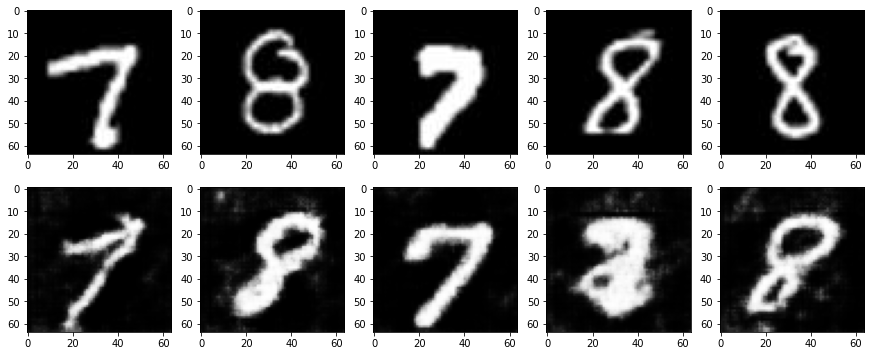

In [26]:
#生成画像と訓練データを可視化．いい感じの画像が出るまで複数回実行していることに注意

device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")

#乱数生成
batch_size=64
z_dim=20
fixed_z=torch.randn(batch_size,z_dim)
fixed_z=fixed_z.view(fixed_z.size(0),fixed_z.size(1),1,1)

#画像生成
fake_images,am1,am2=G_update(fixed_z.to(device))

#訓練データ
batch_iterator=iter(train_dataloader)
imges=next(batch_iterator)

fig=plt.figure(figsize=(15,6))
for i in range(0,5):
    #上段に訓練データ
    plt.subplot(2,5,i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(),'gray')
    
    #下段に生成データ
    plt.subplot(2,5,5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(),'gray')

torch.Size([64, 256, 256])


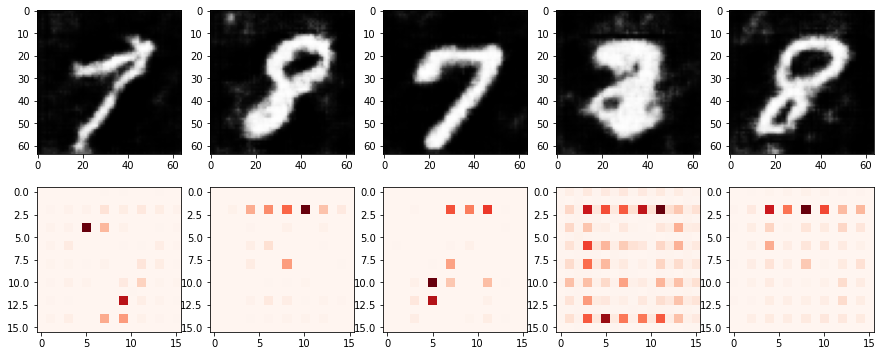

In [27]:
#Attention Mapを出力
fig=plt.figure(figsize=(15,6))
print(am1.size())
for i in range(0,5):
    plt.subplot(2,5,i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(),'gray')
    
    plt.subplot(2,5,i+5+1)
    am=am1[i].view(16,16,16,16)
    am=am[7][7] #中央に注目
    plt.imshow(am.cpu().detach().numpy(),'Reds')